In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [3]:
df = pd.read_csv("data/tech_salaries_encoded.csv")

In [4]:
df.isna().sum()

contrato                                      0
dedicacion                                    0
remainder__salario                            0
remainder__anos_de_experiencia                0
remainder__antiguedad_en_la_empresa_actual    0
remainder__anos_en_el_puesto_actual           0
remainder__cuantas_personas_tenes_a_cargo     0
remainder__edad                               0
remainder__marvin_rol                         0
remainder__cantidad_personas_encoded          0
remainder__modalidad_encoded                  0
remainder__seniority_encoded                  0
dtype: int64

In [5]:
# 1. Preparación final de datos
X = df.drop('remainder__salario', axis=1)  # Asumiendo que 'salario' es tu target
y = df['remainder__salario']

In [6]:
# 2. División estratificada (manteniendo distribución de salarios)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=pd.qcut(y, q=5)  # Estratificación por quintiles salariales
)

In [7]:
# 3. Escalado para mejorar interpretación de coeficientes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# 4. Entrenamiento del modelo con statsmodels (para análisis detallado)
X_train_sm = sm.add_constant(X_train_scaled)
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

In [9]:
# 5. Métricas completas
print("=== Análisis Estadístico del Modelo ===")
print(results.summary())

=== Análisis Estadístico del Modelo ===
                            OLS Regression Results                            
Dep. Variable:     remainder__salario   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     109.3
Date:                Sat, 05 Apr 2025   Prob (F-statistic):          5.58e-206
Time:                        19:49:21   Log-Likelihood:                -40781.
No. Observations:                2668   AIC:                         8.159e+04
Df Residuals:                    2656   BIC:                         8.166e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [10]:
# 6. Predicciones y métricas de performance
X_test_sm = sm.add_constant(X_test_scaled)
y_pred = results.predict(X_test_sm)

In [11]:
print("\n=== Métricas de Evaluación ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"R² Ajustado: {1 - (1-results.rsquared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1):.4f}")


=== Métricas de Evaluación ===
RMSE: 1118245.66
MAE: 858211.29
R²: 0.2261
R² Ajustado: 0.3087


In [12]:
# 8. Análisis de coeficientes (feature importance)
coef_df = pd.DataFrame({
    'feature': ['intercept'] + X.columns.tolist(),
    'coef': results.params,
    'std_err': results.bse,
    't_value': results.tvalues,
    'p_value': results.pvalues
})

print("\n=== Top 10 Variables Más Influyentes ===")
print(coef_df.sort_values('coef', key=abs, ascending=False).head(10))


=== Top 10 Variables Más Influyentes ===
                                          feature          coef       std_err  \
const                                   intercept  2.573454e+06  20417.001451   
x11                  remainder__seniority_encoded  4.774611e+05  27224.944125   
x3                 remainder__anos_de_experiencia  2.189280e+05  29505.338320   
x9           remainder__cantidad_personas_encoded  2.039319e+05  21203.614072   
x10                  remainder__modalidad_encoded  1.550323e+05  21884.529053   
x2                                     dedicacion  1.195494e+05  20668.631576   
x6      remainder__cuantas_personas_tenes_a_cargo  1.149473e+05  21757.341390   
x1                                       contrato -1.133605e+05  21971.701255   
x5            remainder__anos_en_el_puesto_actual -6.835470e+04  25324.648090   
x4     remainder__antiguedad_en_la_empresa_actual -4.934593e+04  25172.696022   

          t_value       p_value  
const  126.044680  0.000000e+00 

In [13]:
# 9. Validación cruzada robusta
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    LinearRegression(),
    X_train_scaled,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
print(f"\nRMSE Promedio Validación Cruzada: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# 10. Benchmark contra modelo base
benchmark = np.ones_like(y_test) * y_train.median()
print(f"\nRMSE Benchmark (mediana): {np.sqrt(mean_squared_error(y_test, benchmark)):.2f}")


RMSE Promedio Validación Cruzada: 1056971.03 ± 32400.57

RMSE Benchmark (mediana): 1306087.96


In [14]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
X_train

,contrato,dedicacion,remainder__anos_de_experiencia,remainder__antiguedad_en_la_empresa_actual,remainder__anos_en_el_puesto_actual,remainder__cuantas_personas_tenes_a_cargo,remainder__edad,remainder__marvin_rol,remainder__cantidad_personas_encoded,remainder__modalidad_encoded,remainder__seniority_encoded
1298,1.0,1.0,3.0,6.0,2.0,1.0,25.0,5.0,8.0,2.0,3.0
2349,1.0,1.0,8.0,6.0,6.0,0.0,30.0,6.0,5.0,1.0,2.0
1523,1.0,1.0,25.0,13.0,1.0,0.0,45.0,3.0,3.0,2.0,2.0
834,1.0,1.0,4.0,2.0,2.0,0.0,31.0,3.0,8.0,2.0,1.0
2231,1.0,1.0,6.0,1.0,3.0,0.0,39.0,2.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1815,1.0,1.0,14.0,0.0,0.0,0.0,44.0,2.0,7.0,1.0,2.0
1270,1.0,1.0,11.0,7.0,3.0,2.0,34.0,6.0,5.0,0.0,3.0
2344,1.0,1.0,3.0,1.0,3.0,0.0,31.0,6.0,5.0,2.0,1.0
765,1.0,1.0,12.0,3.0,3.0,0.0,37.0,3.0,7.0,2.0,2.0


In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(model_xgb, param_grid, n_iter=50, cv=3, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints...
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error')

Mejores parámetros: {'subsample': 0.6, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

=== Métricas XGBoost ===
RMSE: 1,022,493.10
MAE: 800,964.28
R²: 0.3530


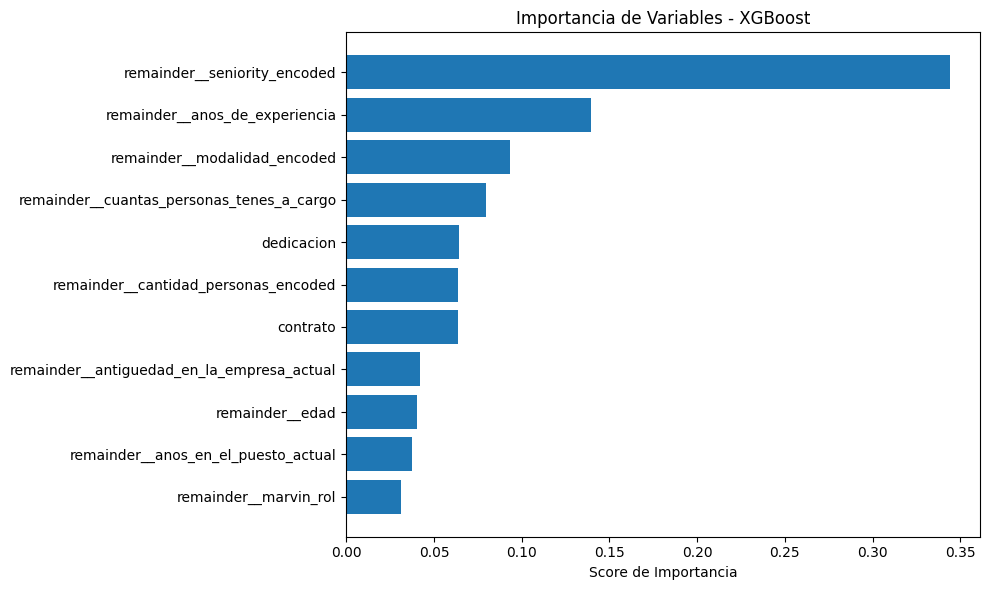


RMSE Validación Cruzada: 1,013,562.34 ± 28,609.34

=== Overfitting Check ===
Train R²: 0.4601
Test R²: 0.3530
Diferencia: 0.1072


In [17]:
# 1. Obtener el mejor modelo y sus parámetros
best_model = search.best_estimator_
print(f"Mejores parámetros: {search.best_params_}\n")

# 2. Predecir en conjunto de prueba
y_pred_xgb = best_model.predict(X_test)

# 3. Calcular métricas clave
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
print("=== Métricas XGBoost ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):,.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):,.2f}")
print(f"R²: {r2_score(y_test, y_pred_xgb):.4f}")

# 5. Feature Importance visual
plt.figure(figsize=(10, 6))
sorted_idx = best_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], best_model.feature_importances_[sorted_idx])
plt.title("Importancia de Variables - XGBoost")
plt.xlabel("Score de Importancia")
plt.tight_layout()
plt.show()

# 6. Validación cruzada robusta
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
print(f"\nRMSE Validación Cruzada: {-cv_scores.mean():,.2f} ± {cv_scores.std():,.2f}")

# 7. Análisis de overfitting (train vs test)
train_pred = best_model.predict(X_train)
print("\n=== Overfitting Check ===")
print(f"Train R²: {r2_score(y_train, train_pred):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"Diferencia: {r2_score(y_train, train_pred) - r2_score(y_test, y_pred_xgb):.4f}")

In [24]:
X_train.iloc[:1].to_dict()

{'contrato': {1298: 1.0},
 'dedicacion': {1298: 1.0},
 'remainder__anos_de_experiencia': {1298: 3.0},
 'remainder__antiguedad_en_la_empresa_actual': {1298: 6.0},
 'remainder__anos_en_el_puesto_actual': {1298: 2.0},
 'remainder__cuantas_personas_tenes_a_cargo': {1298: 1.0},
 'remainder__edad': {1298: 25.0},
 'remainder__marvin_rol': {1298: 5.0},
 'remainder__cantidad_personas_encoded': {1298: 8.0},
 'remainder__modalidad_encoded': {1298: 2.0},
 'remainder__seniority_encoded': {1298: 3.0}}

In [29]:
mis_datos = {'contrato': 1.0,
 'dedicacion': 1.0,
 'remainder__anos_de_experiencia': 2.0,
 'remainder__antiguedad_en_la_empresa_actual': 2.0,
 'remainder__anos_en_el_puesto_actual': 2.0,
 'remainder__cuantas_personas_tenes_a_cargo': 1.0,
 'remainder__edad': 25.0,
 'remainder__marvin_rol': 3.0,
 'remainder__cantidad_personas_encoded': 0.0,
 'remainder__modalidad_encoded': 1.0,
 'remainder__seniority_encoded': 1.0}

In [32]:
mis_datis = pd.DataFrame([mis_datos])

In [33]:
best_model.predict(mis_datis)

array([1848318.5], dtype=float32)